In [1]:
import sys

import torch  # noqa: E402
import random  # noqa: E402
import numpy as np  # noqa: E402
import matplotlib.pyplot as plt
import ot
import importlib

from pydil.utils.Online_GMM import Online_GMM
from pydil.utils.igmm_modif import IGMM

from pydil.ipms.ot_ipms import (  # noqa: E402
    JointWassersteinDistance
)
from pydil.dadil.labeled_dictionary import LabeledDictionary  # noqa: E402
from pydil.dadil.labeled_dictionary_GMM import LabeledDictionaryGMM
from pydil.ot_utils.barycenters import wasserstein_barycenter  # noqa: E402
from pydil.torch_utils.measures import (  # noqa: E402
    UnsupervisedDatasetMeasure,
    SupervisedDatasetMeasure
)

from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.manifold import TSNE
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.mixture import GaussianMixture

C:\Users\SL276123\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\ot\backend.py:2998: UserWarning: To use TensorflowBackend, you need to activate the tensorflow numpy API. You can activate it by running: 
from tensorflow.python.ops.numpy_ops import np_config
np_config.enable_numpy_behavior()
  register_backend(TensorflowBackend())
C:\Users\SL276123\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
dataset = np.load('toy_affine_50d_dataset.npy')

In [3]:
X = dataset[:, :-2]
y = dataset[:, -2]
d = dataset[:, -1]

n_domains = int(np.max(d)) + 1
n_features = X.shape[1]

In [4]:
X.shape, y.shape, d.shape

((1500, 50), (1500,), (1500,))

In [5]:
Xs, ys = [], []
for i in range(n_domains-1):
    Xs.append(torch.from_numpy(X[np.where(d == i)[0]]).float())
    ys.append(torch.from_numpy(y[np.where(d == i)[0]]).float())

In [6]:
Xt = torch.from_numpy(X[np.where(d == n_domains-1)[0]]).float()
yt = torch.from_numpy(y[np.where(d == n_domains-1)[0]]).float()

In [7]:
combined_arrays = list(zip(Xt, yt))

random.seed(0)
# Shuffle the combined arrays
random.shuffle(combined_arrays)

# Unzip the shuffled arrays back into separate arrays
Xt, yt = zip(*combined_arrays)
Xt = torch.stack(Xt, axis=0)
yt = torch.stack(yt, axis=0)

In [8]:
n_samples = 1000
batch_size = 200
n_atoms = 3
n_classes = 10

In [9]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
X_train_t = torch.from_numpy(X_train)
X_test_t = torch.from_numpy(X_test)
X_train_target, X_test_target, y_train_target, y_test_target = train_test_split(X[np.where(d==n_domains-1)[0], :], y[np.where(d==n_domains-1)[0]], test_size=0.2, random_state=0)
X_train_target_t = torch.from_numpy(X_train_target)
X_test_target_t = torch.from_numpy(X_test_target)
dim_reduction = 3

In [10]:
OGMM = IGMM(min_components=10, max_step_components=5, max_components=20)

n_batch = 20
i=0
while i < Xt.shape[0]-n_batch:
    OGMM.train(Xt[i:i+n_batch, :])
    i += n_batch

OGMM.get_GMM()

[[0.17064002768293782,
  array([-1.88963672, -3.95670982, -1.93821239, -3.73457885, -1.86460523,
         -2.31070789,  0.36630052, -4.0917387 , -6.79883997,  0.56036062,
         -2.2570349 , -2.16590303, -3.98787542,  3.44471904, -1.8349659 ,
         -2.8765823 , -0.89579016, -0.07768185,  0.32623014, -1.80455192,
         -4.65652688,  0.03181417, -2.02746781, -4.05914088, -4.79585258,
          1.55736883, -0.65172508, -3.08844137,  0.72280865, -5.03833644,
         -1.02390491,  1.31843885, -2.40704596,  0.00786976, -1.09506146,
         -1.52576542, -2.97186569, -0.7860384 , -2.05134503, -2.06339818,
         -1.98864351, -0.14318547, -1.81083236, -3.29647454, -1.15992695,
         -2.92112994, -0.92181127, -1.25465071, -4.07626335, -0.97149311]),
  array([[0.02532198, 0.04381378, 0.01633453, ..., 0.01677115, 0.03437514,
          0.00360795],
         [0.04381378, 0.07604755, 0.02842345, ..., 0.02886164, 0.06021608,
          0.00639604],
         [0.01633453, 0.02842345, 0.010

In [11]:
%%script false --no-exec

range_data = np.mean(np.max(X[np.where(d!=n_domains-1)[0], :], axis=0) - np.min(X[np.where(d!=n_domains-1)[0], :], axis=0))

dim_reduction = 3
n_gaussians = 10
OGMM = Online_GMM(
    n_components=n_gaussians, 
    lr=0.1,
    n_features=dim_reduction,
    data_range=range_data,
    batch_size=batch_size
)

i=0
while i < Xt.shape[0]-dim_reduction:
    OGMM.fit_sample(Xt[i:i+dim_reduction, :], dimension_reduction=True)
    i += dim_reduction
OGMM.get_GMM()

Couldn't find program: 'false'


In [11]:
n_gaussians = 10
sklearn_GMM = GaussianMixture(n_components=n_gaussians, random_state=0)
sklearn_GMM.fit(Xt)

GaussianMixture(n_components=10, random_state=0)

## Tests on the GMM

In [ ]:
np.sum(OGMM.score_samples(Xt, dimension_reduction=True))

In [15]:
np.sum(OGMM.score_samples(Xt))

c:\Users\SL276123\Documents\Online DaDiL\PyDiL-main\PyDiL-main\pydil\utils\igmm.py:696: RuntimeWarning: divide by zero encountered in log
  return -len(x)/2*np.log(2*np.pi) - 1/2*(np.log(np.linalg.det(cov)) + (x - mean).T @ np.linalg.inv(cov) @ (x - mean))
c:\Users\SL276123\Documents\Online DaDiL\PyDiL-main\PyDiL-main\pydil\utils\igmm.py:696: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matrices or `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at ..\aten\src\ATen\native\TensorShape.cpp:3575.)
  return -len(x)/2*np.log(2*np.pi) - 1/2*(np.log(np.linalg.det(cov)) + (x - mean).T @ np.linalg.inv(cov) @ (x - mean))


inf

In [16]:
np.sum(sklearn_GMM.score_samples(Xt))

143919.22888967206

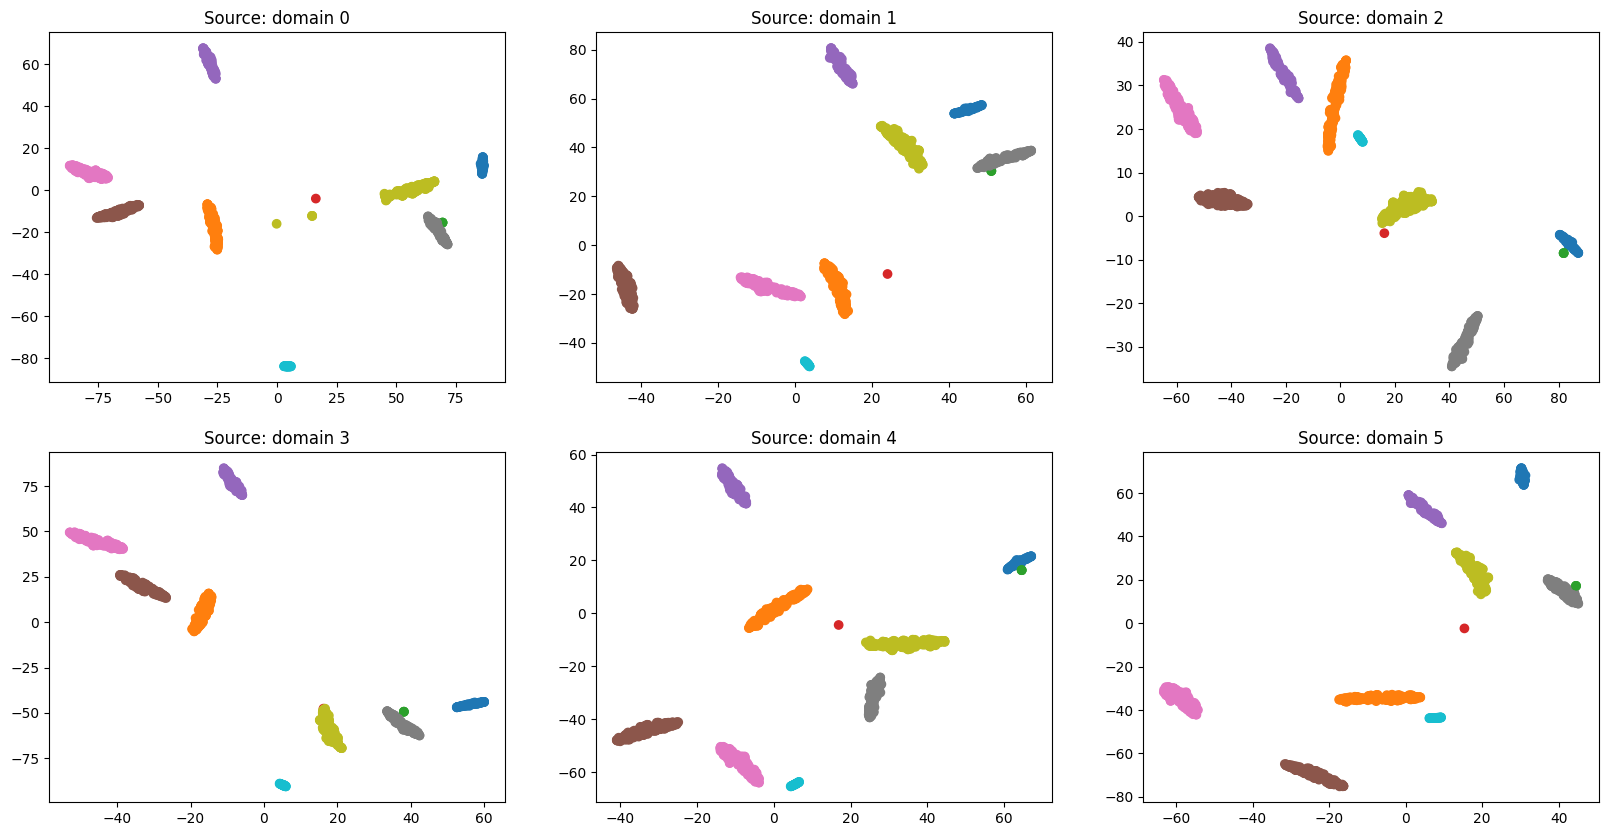

In [29]:
tsne = TSNE(n_components=2)
proj = tsne.fit_transform(
    torch.cat(Xs + [Xt], dim=0)
)
names = [f'domain {i}' for i in range(7)]
target_name = names[-1]

fig, axes = plt.subplots(2, 3, figsize=(20, 10))

markers = ['o', '^', 'P', 'D']
for k, ax in enumerate(axes.flatten()):
    ind = np.where(d == k)[0]
    ax.scatter(proj[ind, 0],
               proj[ind, 1],
               c=torch.cat(ys + [yt], dim=0)[ind],
               cmap='tab10')
    if names[k] == target_name:
        ax.set_title(f'Target: {names[k]}')
    else:
        ax.set_title(f'Source: {names[k]}')


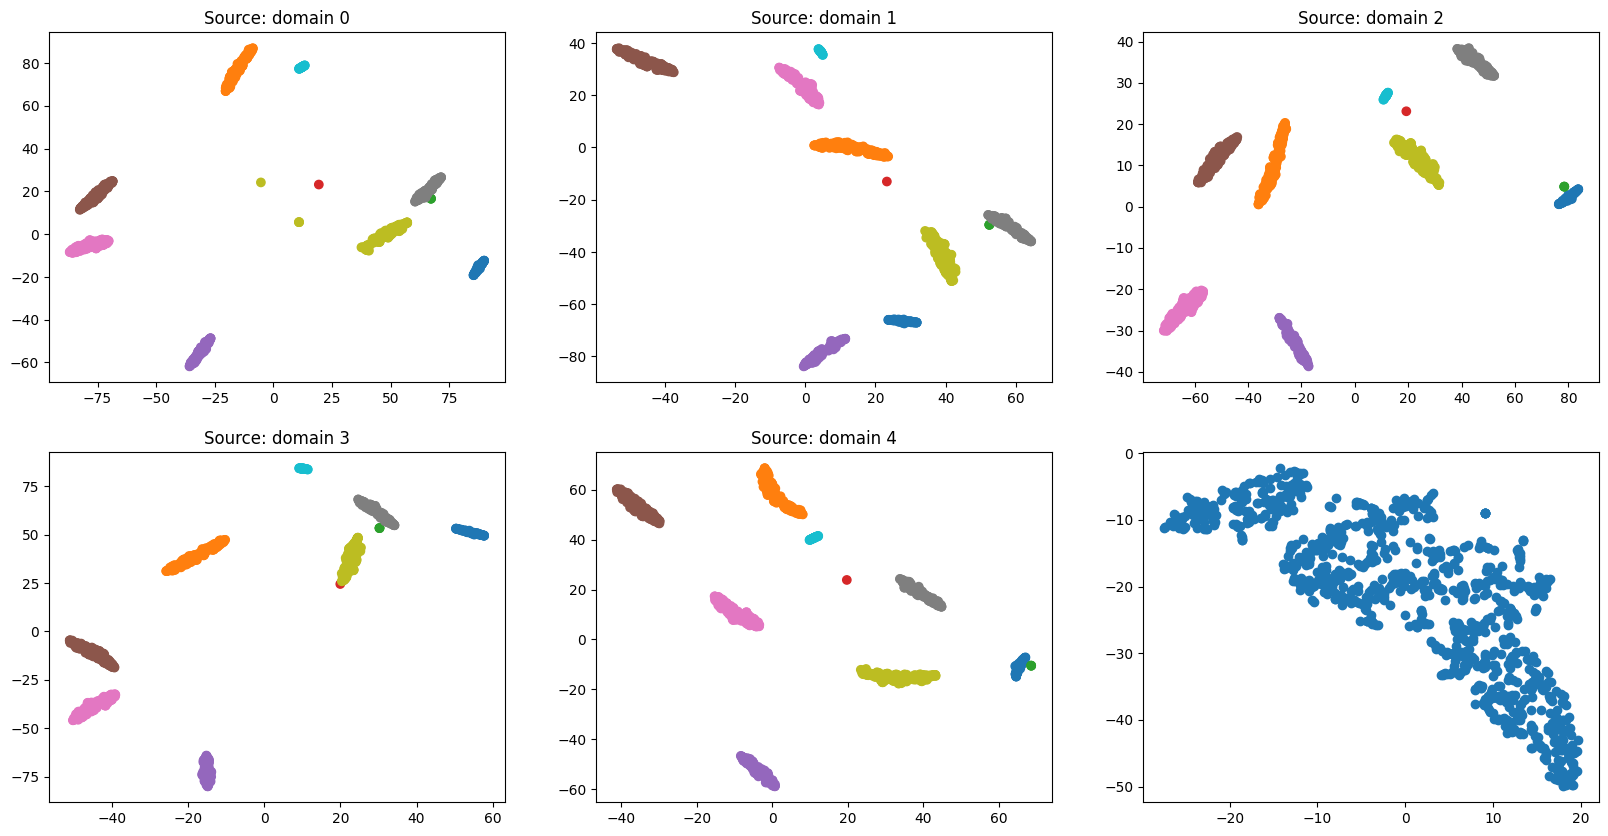

In [30]:
tsne = TSNE(n_components=2)
proj = tsne.fit_transform(
    torch.cat(Xs + [OGMM.sample(1000)[0]], dim=0)
)
names = [f'domain {i}' for i in range(7)]
target_name = names[-1]

fig, axes = plt.subplots(2, 3, figsize=(20, 10))

markers = ['o', '^', 'P', 'D']
for k, ax in enumerate(axes.flatten()[:-1]):
    ind = np.where(d == k)[0]
    ax.scatter(proj[ind, 0],
               proj[ind, 1],
               c=torch.cat(ys, dim=0)[ind],
               cmap='tab10')
    if names[k] == target_name:
        ax.set_title(f'Target: {names[k]}')
    else:
        ax.set_title(f'Source: {names[k]}')
ind = np.where(d == n_domains-1)[0]
axes.flatten()[-1].scatter(proj[ind, 0],
               proj[ind, 1])

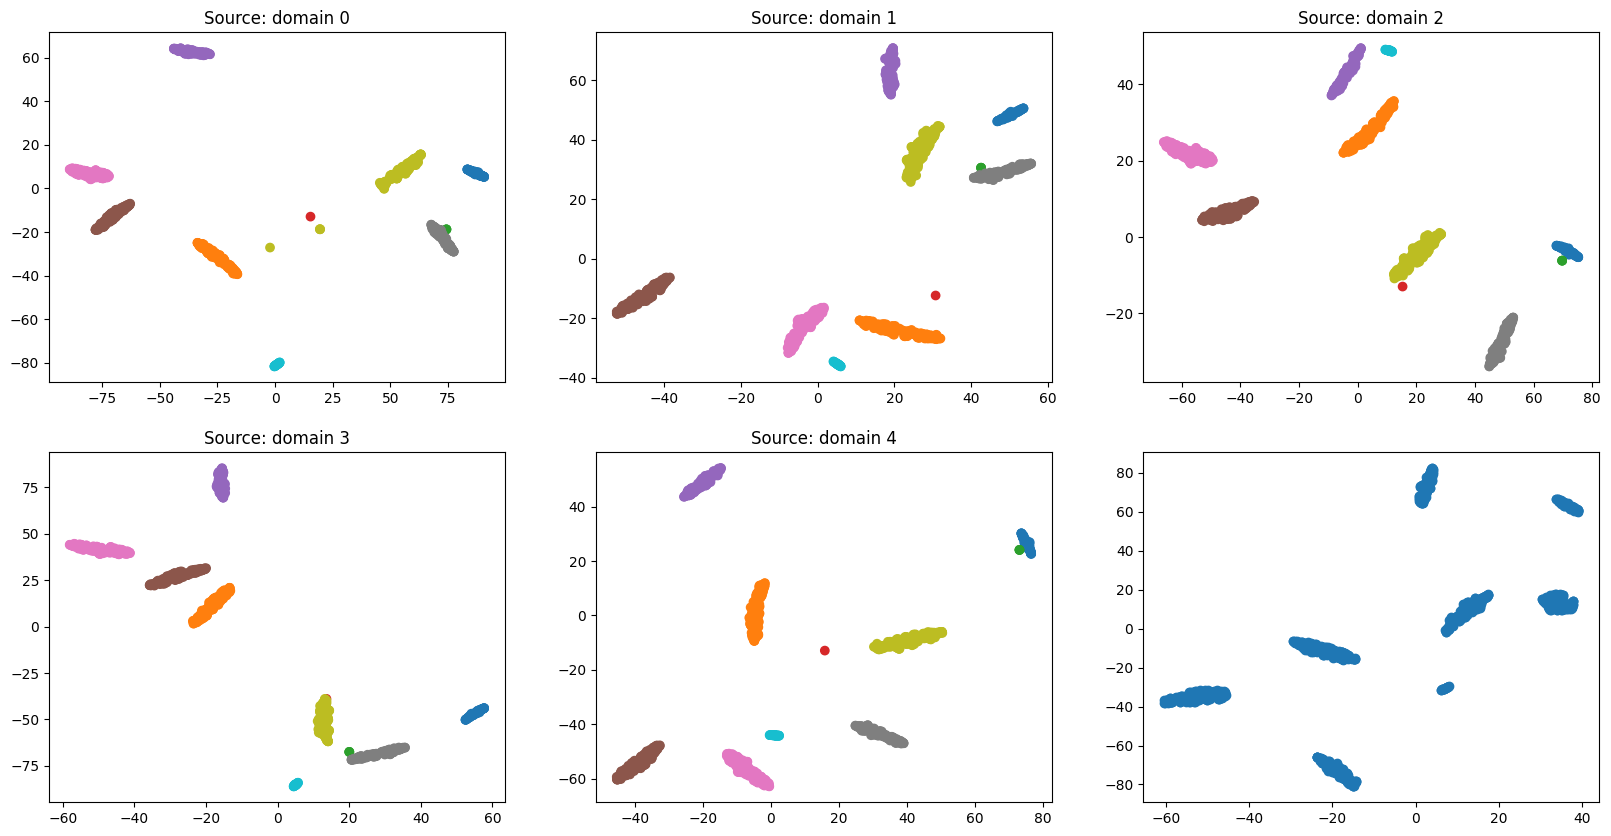

In [31]:
tsne = TSNE(n_components=2)
proj = tsne.fit_transform(
    torch.cat(Xs + [torch.from_numpy(sklearn_GMM.sample(1000)[0]).float()], dim=0)
)
names = [f'domain {i}' for i in range(7)]
target_name = names[-1]

fig, axes = plt.subplots(2, 3, figsize=(20, 10))

markers = ['o', '^', 'P', 'D']
for k, ax in enumerate(axes.flatten()[:-1]):
    ind = np.where(d == k)[0]
    ax.scatter(proj[ind, 0],
               proj[ind, 1],
               c=torch.cat(ys, dim=0)[ind],
               cmap='tab10')
    if names[k] == target_name:
        ax.set_title(f'Target: {names[k]}')
    else:
        ax.set_title(f'Source: {names[k]}')
ind = np.where(d == n_domains-1)[0]
axes.flatten()[-1].scatter(proj[ind, 0],
               proj[ind, 1])

Test to determine the best n_gaussians

In [ ]:
%%script false --no-exec
range_data = np.mean(np.max(X[np.where(d!=6)[0], :], axis=0) - np.min(X[np.where(d!=6)[0], :], axis=0))

n_gaussians = np.linspace(10, 60, 6)
ll = []
for n_gauss in n_gaussians:
    OGMM = Online_GMM(
        n_components=n_gauss, 
        lr=0.1,
        n_features=dim_reduction,
        data_range=range_data,
        batch_size=batch_size
    )
    
    i = 0
    while i < X_train_target_t.shape[0]-dim_reduction:
        OGMM.fit_sample(X_train_target_t[i:i+dim_reduction, :], dimension_reduction=True)
        i += dim_reduction

    print(OGMM.get_GMM())
    ll.append(OGMM.score_samples(X_test_target_t, dimension_reduction=True))

## Dictionary learning seperated between sources and target with Online_GMM simultaneously

In [123]:
Q_sources = []
for Xs_k, ys_k in zip(Xs, ys):
    Q_sources.append(
        SupervisedDatasetMeasure(
            features=Xs_k.numpy(),
            labels=ys_k.numpy(),
            stratify=True,
            batch_size=batch_size,
            device='cpu'
        )
    )

criterion = JointWassersteinDistance()

dictionary_sources = LabeledDictionaryGMM(XP=None,
                           YP=None,
                           A=None,
                           n_samples=n_samples,
                           n_dim=X.shape[1],
                           n_classes=n_classes,
                           n_components=n_atoms,
                           weight_initialization='uniform',
                           n_distributions=len(Q_sources),
                           loss_fn=criterion,
                           learning_rate_features=1e-1,
                           learning_rate_labels=1e-1,
                           learning_rate_weights=1e-1,
                           reg_e=0.0,
                           n_iter_barycenter=10,
                           n_iter_sinkhorn=20,
                           n_iter_emd=1000000,
                           domain_names=None,
                           grad_labels=True,
                           optimizer_name='Adam',
                           balanced_sampling=True,
                           sampling_with_replacement=True,
                           barycenter_tol=1e-9,
                           barycenter_beta=None,
                           tensor_dtype=torch.float32,
                           track_atoms=False,
                           schedule_lr=False)

dictionary_sources.fit(Q_sources,
               n_iter_max=60,
               batches_per_it=n_samples // batch_size,
               verbose=True)

It 1/60, Loss: 35340.381640625004
It 2/60, Loss: 25661.6171875
It 3/60, Loss: 18329.6541015625
It 4/60, Loss: 13929.1373046875
It 5/60, Loss: 11737.655664062499
It 6/60, Loss: 10583.7525390625
It 7/60, Loss: 9893.4458984375
It 8/60, Loss: 9509.924609374999
It 9/60, Loss: 9064.2279296875
It 10/60, Loss: 8778.56015625
It 11/60, Loss: 8474.352734375
It 12/60, Loss: 8350.838281249999
It 13/60, Loss: 8198.25390625
It 14/60, Loss: 8059.867382812501
It 15/60, Loss: 7839.5130859375
It 16/60, Loss: 7755.516503906249
It 17/60, Loss: 7664.584179687501
It 18/60, Loss: 7587.828125
It 19/60, Loss: 7448.356542968751
It 20/60, Loss: 7394.1142578125
It 21/60, Loss: 7295.5013671875
It 22/60, Loss: 7209.941796875
It 23/60, Loss: 7215.52822265625
It 24/60, Loss: 7141.26328125
It 25/60, Loss: 7002.2033203125
It 26/60, Loss: 7011.15029296875
It 27/60, Loss: 6912.6548828125
It 28/60, Loss: 6892.283886718749
It 29/60, Loss: 6754.24609375
It 30/60, Loss: 6731.631738281249
It 31/60, Loss: 6551.723339843751
It 3

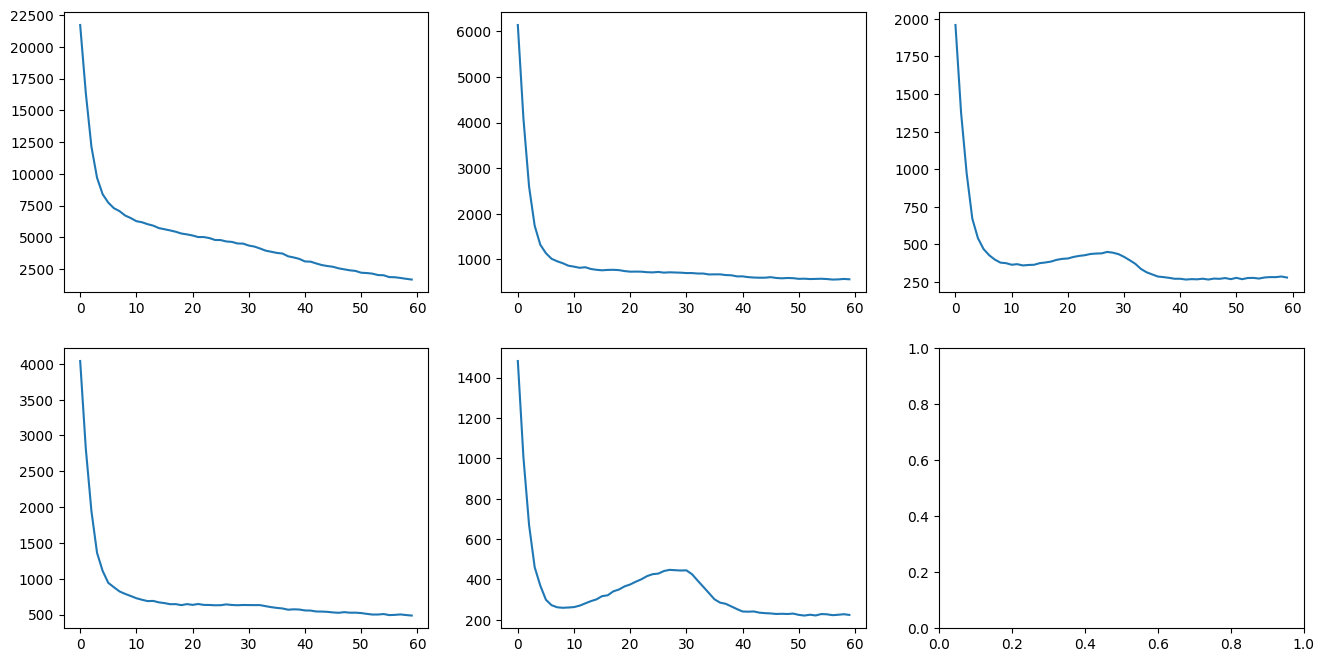

In [124]:
XP_sources = dictionary_sources.XP
YP_sources = dictionary_sources.YP

names_sources = [f'domain {i}' for i in range(6)]

fig, axes = plt.subplots(2, 3, figsize=(16, 8))
for k, dom in enumerate(dictionary_sources.history['loss_per_dataset']):
    axes.flatten()[k].plot(dictionary_sources.history['loss_per_dataset'][dom])

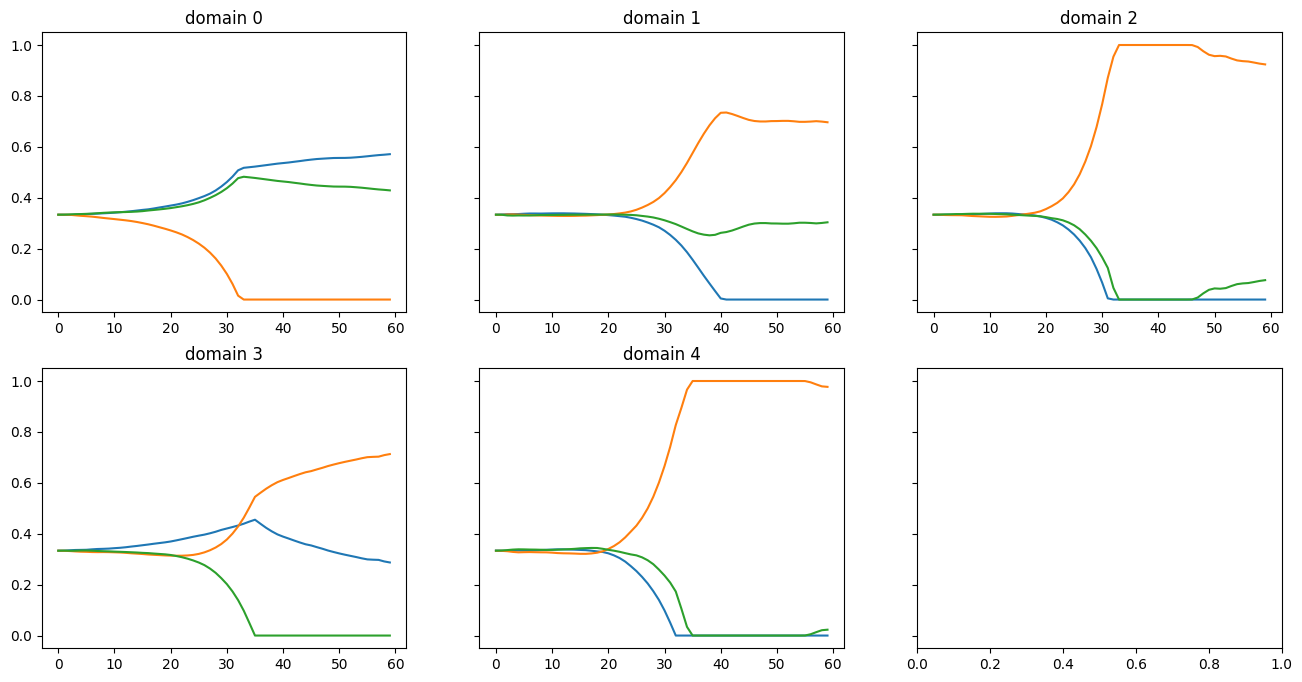

In [125]:
fig, axes = plt.subplots(2, 3, figsize=(16, 8), sharey=True)

for k, (name, ax) in enumerate(zip(names_sources, axes.flatten()[:-1])):
    ax.plot(torch.stack(dictionary_sources.history['weights'])[:, k, :])
    ax.set_title(name)

In [126]:
dim_reduction = 20
range_data = np.mean(np.max(X[np.where(d!=n_domains-1)[0], :], axis=0) - np.min(X[np.where(d!=n_domains-1)[0], :], axis=0))


In [127]:
dictionary_target = LabeledDictionaryGMM(XP=XP_sources,
                           YP=YP_sources,
                           A=None,
                           n_samples=n_samples,
                           n_dim=X.shape[1],
                           n_classes=n_classes,
                           n_components=n_atoms,
                           weight_initialization='uniform',
                           n_distributions=1,
                           loss_fn=criterion,
                           learning_rate_features=0,
                           learning_rate_labels=0,
                           learning_rate_weights=1e-1,
                           reg_e=0.0,
                           n_iter_barycenter=10,
                           n_iter_sinkhorn=20,
                           n_iter_emd=1000000,
                           domain_names=None,
                           grad_labels=True,
                           optimizer_name='Adam',
                           balanced_sampling=True,
                           sampling_with_replacement=True,
                           barycenter_tol=1e-9,
                           barycenter_beta=None,
                           tensor_dtype=torch.float32,
                           track_atoms=False,
                           schedule_lr=False,
                           GMM_components=n_gaussians,
                           GMM_dim_reduction=dim_reduction,
                           data_range=range_data)

i = 0
while i < Xt.shape[0]-dim_reduction:
    print(i)
    dictionary_target.fit_target_sample(Xt[i:i+dim_reduction, :],
                                        batches_per_it=n_samples // batch_size,
                                        batch_size=batch_size,
                                        verbose=True,
                                        regularization=False,)
    i += dim_reduction

0
Loss: 1126.39072265625
20
Loss: 1093.53154296875
40
Loss: 1097.5667968750001
60
Loss: 1079.637158203125
80
Loss: 1079.4870361328124
100
Loss: 1077.7235351562501
120
Loss: 1085.4877685546876
140
Loss: 1084.0923828125
160
Loss: 1084.035595703125
180
Loss: 1101.0921630859375
200
Loss: 1081.824951171875
220
Loss: 1091.6952392578125


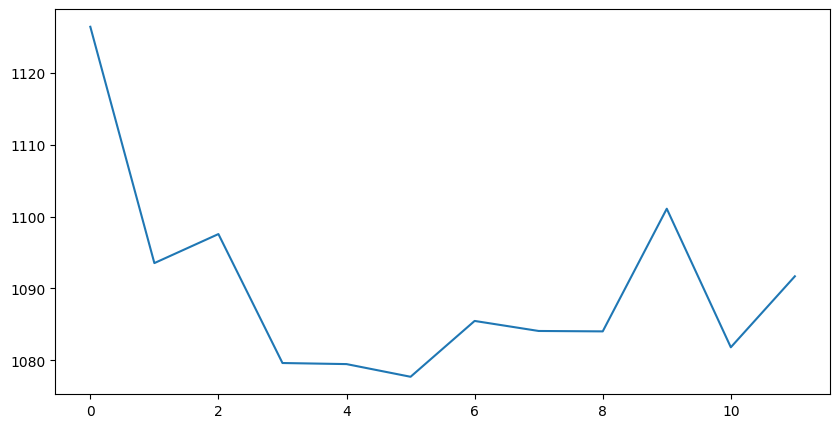

In [128]:
target_name = 'Domain 7'
fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(dictionary_target.history['loss_per_dataset']['Domain 0'])

Text(0.5, 1.0, 'Domain 7')

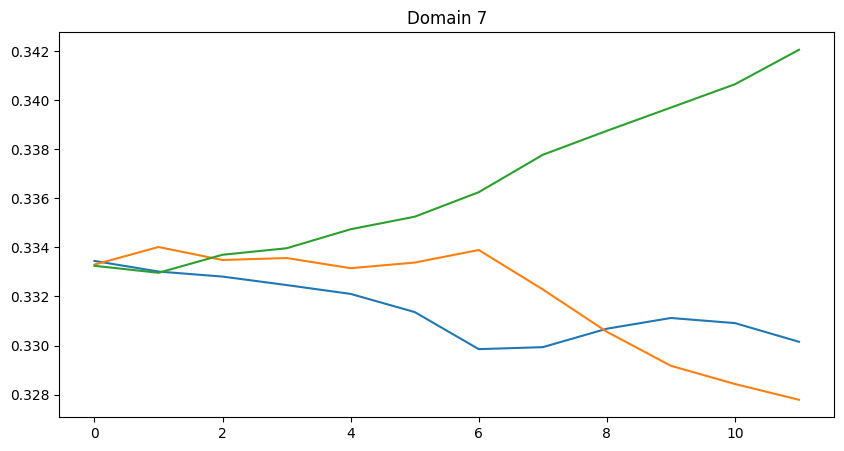

In [129]:
fig, ax = plt.subplots(figsize=(10, 5))

ax.plot(torch.stack(dictionary_target.history['weights'])[:, -1, :])
ax.set_title(target_name)

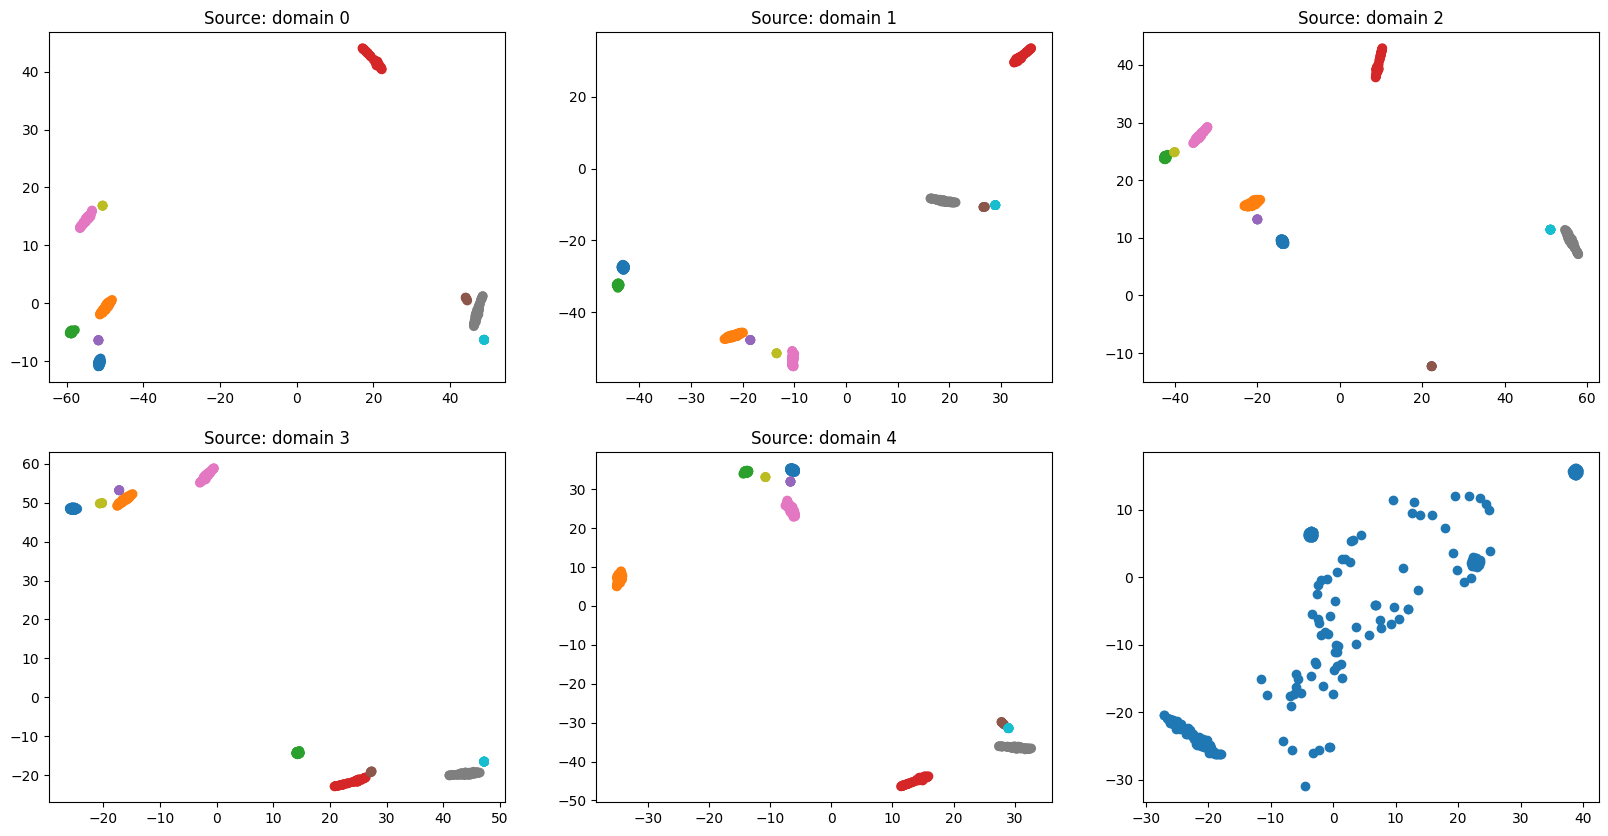

In [130]:
tsne = TSNE(n_components=2)
proj = tsne.fit_transform(
    torch.cat(Xs + [dictionary_target.OGMM.sample(1000)[0]], dim=0)
)
names = [f'domain {i}' for i in range(7)]
target_name = names[-1]

fig, axes = plt.subplots(2, 3, figsize=(20, 10))

markers = ['o', '^', 'P', 'D']
for k, ax in enumerate(axes.flatten()[:-1]):
    ind = np.where(d == k)[0]
    ax.scatter(proj[ind, 0],
               proj[ind, 1],
               c=torch.cat(ys, dim=0)[ind],
               cmap='tab10')
    if names[k] == target_name:
        ax.set_title(f'Target: {names[k]}')
    else:
        ax.set_title(f'Source: {names[k]}')
ind = np.where(d == n_domains-1)[0]
axes.flatten()[-1].scatter(proj[ind, 0],
               proj[ind, 1])

In [131]:
weights = dictionary_target.A[-1, :].detach()
print(weights)
XP = [XPk.detach().clone() for XPk in dictionary_target.XP]
YP = [YPk.detach().clone().softmax(dim=-1) for YPk in dictionary_target.YP]

Xr, Yr = dictionary_target.reconstruct(weights=weights)

tensor([0.3302, 0.3278, 0.3421])


Classification without DA

In [137]:
clf = SVC(kernel='rbf')
#clf = RandomForestClassifier(criterion='gini')

clf.fit(torch.cat(Xs, dim=0),
        torch.cat(ys, dim=0))
yp = clf.predict(Xt)
print(accuracy_score(yp, yt))

0.908


DaDiL-E

In [187]:
clf = SVC(kernel='linear', probability=True)
#clf = RandomForestClassifier(criterion='gini')

predictions = []
for k, (XP_k, YP_k) in enumerate(zip(XP, YP)):
    # Get atom data
    XP_k, YP_k = XP_k.data.cpu(), YP_k.data.cpu()
    yp_k = YP_k.argmax(dim=1)
    
    clf.fit(XP_k, yp_k)
    yp = clf.predict(Xt)
    print("Atom {} w/ weight {} got {}".format(k, np.round(weights[k], 3), accuracy_score(yt, yp)))

    P = clf.predict_proba(Xt)
    predictions.append(P)
predictions = np.stack(predictions)

# Weights atomic model predictions
yp = np.einsum('i,inj->nj', weights, predictions).argmax(axis=1)

# Compute statistics
accuracy_e = accuracy_score(yt, yp)
print(accuracy_e)

Atom 0 w/ weight 0.33000001311302185 got 0.304
Atom 1 w/ weight 0.328000009059906 got 0.636
Atom 2 w/ weight 0.34200000762939453 got 0.196
0.56


DaDiL-R

In [189]:
clf = SVC(kernel='linear')
#clf = RandomForestClassifier(criterion='gini')

clf.fit(Xr, Yr.argmax(dim=1))
yp = clf.predict(Xt)
accuracy_r = accuracy_score(yp, yt)
print(accuracy_r)

0.704


Final optimal transport to adapt domains

In [148]:
clf = SVC(kernel='linear', probability=True)
#clf = RandomForestClassifier()

predictions = []
for k, (XP_k, YP_k) in enumerate(zip(XP, YP)):
    # Get atom data
    XP_k, YP_k = XP_k.data.cpu(), YP_k.data.cpu()
    Xt_OGMM = OGMM.sample(XP_k.shape[0])[0]

    weights_k = torch.ones(XP_k.shape[0])/XP_k.shape[0]
    weights_ogmm = torch.ones(Xt_OGMM.shape[0])/Xt_OGMM.shape[0]

    C = torch.cdist(XP_k, Xt_OGMM, p=2) ** 2
    ot_plan = ot.emd(weights_k, weights_ogmm, C, numItermax=1000000)
    Yt_OGMM = ot_plan.T @ YP_k

    yt_ogmm = Yt_OGMM.argmax(dim=1)
    
    clf.fit(Xt_OGMM, yt_ogmm)
    yp = clf.predict(Xt)
    print("Atom {} w/ weight {} got {}".format(k, np.round(weights[k], 3), accuracy_score(yt, yp)))

    P = clf.predict_proba(Xt)
    predictions.append(P)
predictions = np.stack(predictions)

# Weights atomic model predictions
yp = np.einsum('i,inj->nj', weights, predictions).argmax(axis=1)

# Compute statistics
accuracy_e = accuracy_score(yt, yp)
print(accuracy_e)

Atom 0 w/ weight 0.33000001311302185 got 0.752
Atom 1 w/ weight 0.328000009059906 got 0.8
Atom 2 w/ weight 0.34200000762939453 got 0.792
0.856


In [186]:
Xt_OGMM = OGMM.sample(Xr.shape[0])[0]

weights_r = torch.ones(Xr.shape[0])/Xr.shape[0]
weights_ogmm = torch.ones(Xt_OGMM.shape[0])/Xt_OGMM.shape[0]

C = torch.cdist(Xr, Xt_OGMM, p=2) ** 2
ot_plan = ot.emd(weights_r, weights_ogmm, C, numItermax=1000000)
Yt_OGMM = ot_plan.T @ Yr

clf = SVC(kernel='rbf')
#clf = RandomForestClassifier(criterion='gini')

clf.fit(Xt_OGMM, Yt_OGMM.argmax(dim=1))
yp = clf.predict(Xt)
accuracy_r = accuracy_score(yp, yt)
print(accuracy_r)

0.86


## Dictionary learning seperated between sources and target

In [148]:
Q_sources = []
for Xs_k, ys_k in zip(Xs, ys):
    Q_sources.append(
        SupervisedDatasetMeasure(
            features=Xs_k.numpy(),
            labels=ys_k.numpy(),
            stratify=True,
            batch_size=batch_size,
            device='cpu'
        )
    )
    
Q_target = [OGMM]

Q_sources_and_target = Q_sources + Q_target

In [149]:
criterion = JointWassersteinDistance()

In [150]:
dictionary_sources = LabeledDictionaryGMM(XP=None,
                           YP=None,
                           A=None,
                           n_samples=n_samples,
                           n_dim=X.shape[1],
                           n_classes=n_classes,
                           n_components=n_atoms,
                           weight_initialization='uniform',
                           n_distributions=len(Q_sources),
                           loss_fn=criterion,
                           learning_rate_features=1e-1,
                           learning_rate_labels=1e-1,
                           learning_rate_weights=1e-1,
                           reg_e=0.0,
                           n_iter_barycenter=10,
                           n_iter_sinkhorn=20,
                           n_iter_emd=1000000,
                           domain_names=None,
                           grad_labels=True,
                           optimizer_name='Adam',
                           balanced_sampling=True,
                           sampling_with_replacement=True,
                           barycenter_tol=1e-9,
                           barycenter_beta=None,
                           tensor_dtype=torch.float32,
                           track_atoms=False,
                           schedule_lr=False)

In [151]:
dictionary_sources.fit(Q_sources,
               n_iter_max=60,
               batches_per_it=n_samples // batch_size,
               verbose=True)

It 1/60, Loss: 6811.979980468751
It 2/60, Loss: 4561.91826171875
It 3/60, Loss: 2949.80390625
It 4/60, Loss: 2065.2195556640627
It 5/60, Loss: 1713.1765380859374
It 6/60, Loss: 1479.4699951171874
It 7/60, Loss: 1339.6915039062499
It 8/60, Loss: 1276.7452880859373
It 9/60, Loss: 1212.3653076171875
It 10/60, Loss: 1163.9464111328125
It 11/60, Loss: 1132.1940673828124
It 12/60, Loss: 1103.9516357421876
It 13/60, Loss: 1085.3390625000002
It 14/60, Loss: 1080.1459228515625
It 15/60, Loss: 1025.7579223632813
It 16/60, Loss: 1015.3780761718749
It 17/60, Loss: 1000.5501708984375
It 18/60, Loss: 1023.8056274414062
It 19/60, Loss: 992.5769653320314
It 20/60, Loss: 978.8472290039061
It 21/60, Loss: 984.0693725585936
It 22/60, Loss: 972.1728637695312
It 23/60, Loss: 955.9900756835939
It 24/60, Loss: 936.7345458984375
It 25/60, Loss: 922.2802612304687
It 26/60, Loss: 926.8438232421875
It 27/60, Loss: 870.6769287109375
It 28/60, Loss: 842.4213256835936
It 29/60, Loss: 825.437353515625
It 30/60, Loss

In [152]:
XP_sources = dictionary_sources.XP
YP_sources = dictionary_sources.YP

In [153]:
names_sources = [f'domain {i}' for i in range(6)]

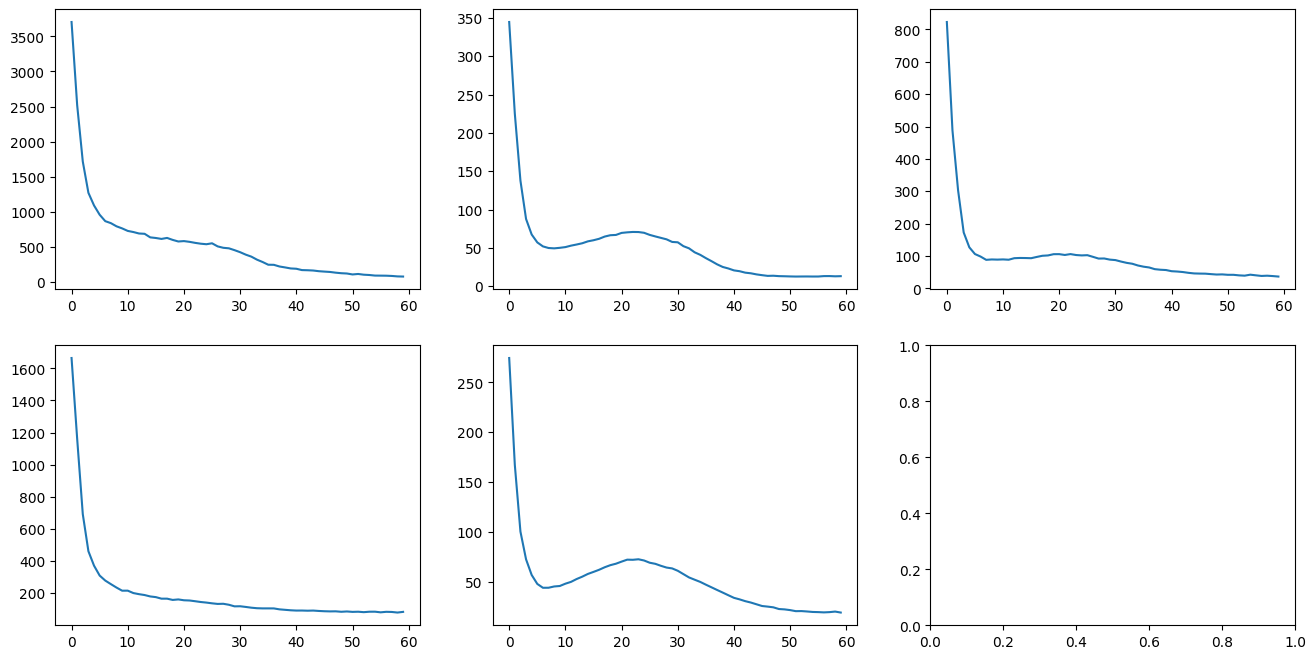

In [154]:
fig, axes = plt.subplots(2, 3, figsize=(16, 8))
for k, dom in enumerate(dictionary_sources.history['loss_per_dataset']):
    axes.flatten()[k].plot(dictionary_sources.history['loss_per_dataset'][dom])

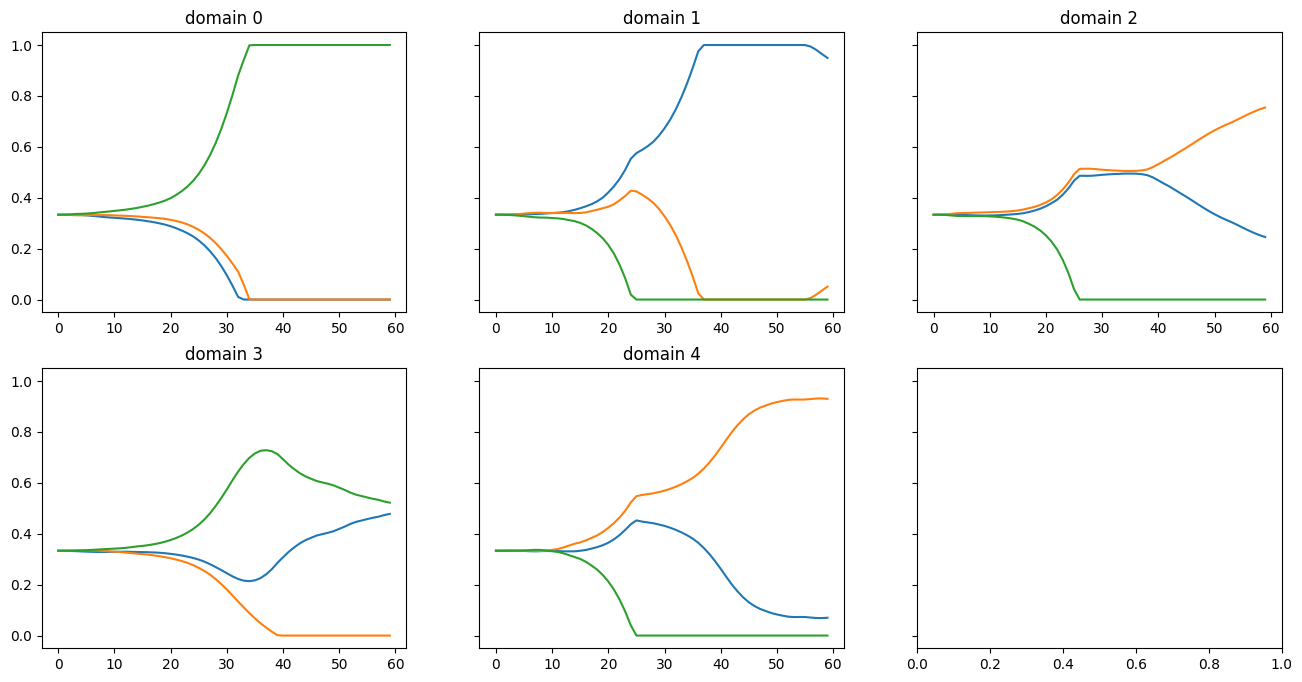

In [155]:
fig, axes = plt.subplots(2, 3, figsize=(16, 8), sharey=True)

for k, (name, ax) in enumerate(zip(names_sources, axes.flatten()[:-1])):
    ax.plot(torch.stack(dictionary_sources.history['weights'])[:, k, :])
    ax.set_title(name)

In [156]:
dictionary_target = LabeledDictionaryGMM(XP=XP_sources,
                           YP=YP_sources,
                           A=None,
                           n_samples=n_samples,
                           n_dim=X.shape[1],
                           n_classes=n_classes,
                           n_components=n_atoms,
                           weight_initialization='uniform',
                           n_distributions=len(Q_target),
                           loss_fn=criterion,
                           learning_rate_features=0,
                           learning_rate_labels=0,
                           learning_rate_weights=1e-1,
                           reg_e=0.0,
                           n_iter_barycenter=10,
                           n_iter_sinkhorn=20,
                           n_iter_emd=1000000,
                           domain_names=None,
                           grad_labels=True,
                           optimizer_name='Adam',
                           balanced_sampling=True,
                           sampling_with_replacement=True,
                           barycenter_tol=1e-9,
                           barycenter_beta=None,
                           tensor_dtype=torch.float32,
                           track_atoms=False,
                           schedule_lr=False)

In [157]:
dictionary_target.fit(Q_target,
               n_iter_max=40,
               batches_per_it=n_samples // batch_size,
               verbose=True,
               regularization=False)

It 1/40, Loss: 105.94940643310547
It 2/40, Loss: 102.3138916015625
It 3/40, Loss: 100.70666351318359
It 4/40, Loss: 104.24326782226564
It 5/40, Loss: 105.36407470703125
It 6/40, Loss: 100.97377319335936
It 7/40, Loss: 105.42977294921874
It 8/40, Loss: 113.99273986816408
It 9/40, Loss: 104.43627166748047
It 10/40, Loss: 105.07008666992188
It 11/40, Loss: 99.160302734375
It 12/40, Loss: 106.98026580810547
It 13/40, Loss: 104.40335540771484
It 14/40, Loss: 100.71348724365234
It 15/40, Loss: 110.29284973144533
It 16/40, Loss: 106.6973907470703
It 17/40, Loss: 111.34894104003907
It 18/40, Loss: 107.89900054931641
It 19/40, Loss: 105.51728515625001
It 20/40, Loss: 108.06456146240235
It 21/40, Loss: 109.65324096679689
It 22/40, Loss: 102.43630828857422
It 23/40, Loss: 96.41658020019531
It 24/40, Loss: 112.88636627197266
It 25/40, Loss: 110.97306213378906
It 26/40, Loss: 112.72770233154297
It 27/40, Loss: 102.13374786376954
It 28/40, Loss: 106.38578033447267
It 29/40, Loss: 101.5913070678711
I

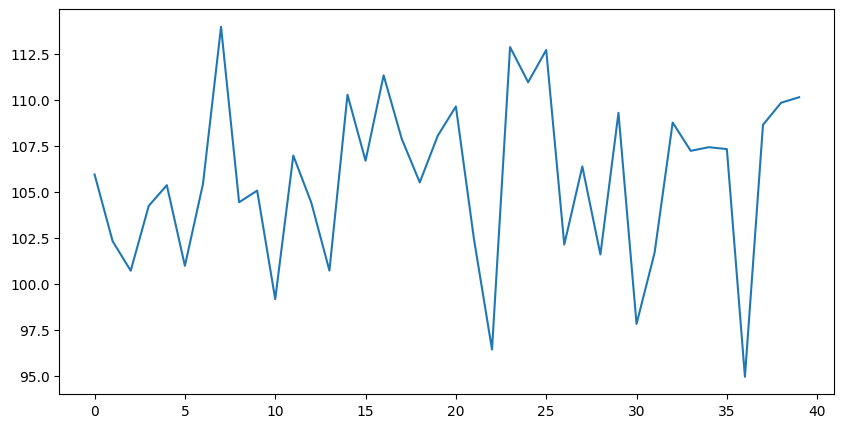

In [158]:
target_name = 'Domain 7'
fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(dictionary_target.history['loss_per_dataset']['Domain 0'])

Text(0.5, 1.0, 'Domain 7')

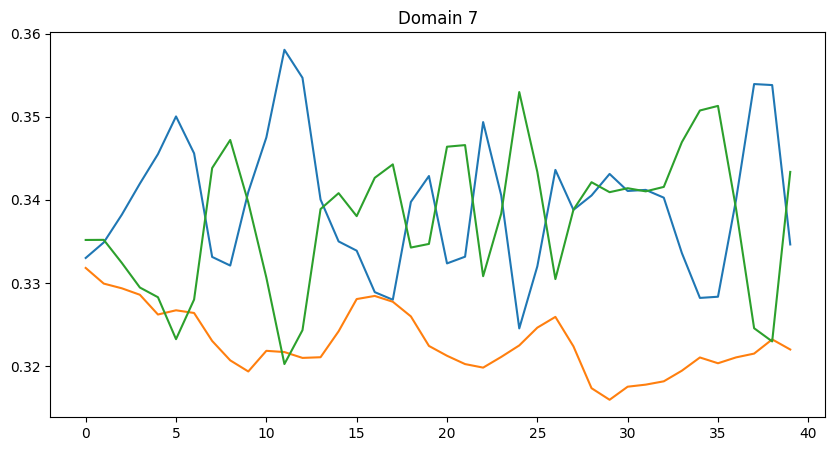

In [159]:
fig, ax = plt.subplots(figsize=(10, 5))

ax.plot(torch.stack(dictionary_target.history['weights'])[:, -1, :])
ax.set_title(target_name)

In [160]:
weights = dictionary_target.A[-1, :].detach()
print(weights)
XP = [XPk.detach().clone() for XPk in dictionary_target.XP]
YP = [YPk.detach().clone().softmax(dim=-1) for YPk in dictionary_target.YP]

tensor([0.3346, 0.3220, 0.3434])


In [161]:
Xr, Yr = dictionary_target.reconstruct(weights=weights)

Classification without DA

In [162]:
clf = SVC(kernel='linear')
#clf = RandomForestClassifier(criterion = 'gini')
clf.fit(torch.cat(Xs, dim=0),
        torch.cat(ys, dim=0))
yp = clf.predict(Xt)
print(accuracy_score(yp, yt))

0.611


DaDiL-E

In [176]:
clf = SVC(kernel='linear', probability=True)
#clf = RandomForestClassifier(criterion = 'gini')

predictions = []
for k, (XP_k, YP_k) in enumerate(zip(XP, YP)):
    # Get atom data
    XP_k, YP_k = XP_k.data.cpu(), YP_k.data.cpu()
    yp_k = YP_k.argmax(dim=1)
    
    clf.fit(XP_k, yp_k)
    yp = clf.predict(Xt)
    print("Atom {} w/ weight {} got {}".format(k, np.round(weights[k], 3), accuracy_score(yt, yp)))

    P = clf.predict_proba(Xt)
    predictions.append(P)
predictions = np.stack(predictions)

# Weights atomic model predictions
yp = np.einsum('i,inj->nj', weights, predictions).argmax(axis=1)

# Compute statistics
accuracy_e = accuracy_score(yt, yp)
print(accuracy_e)

Atom 0 w/ weight 0.33500000834465027 got 0.168
Atom 1 w/ weight 0.32199999690055847 got 0.478
Atom 2 w/ weight 0.34299999475479126 got 0.521
0.435


DaDiL-R

In [183]:
clf = SVC(kernel='linear')
clf = RandomForestClassifier(criterion = 'gini')

clf.fit(Xr, Yr.argmax(dim=1))
yp = clf.predict(Xt)
accuracy_r = accuracy_score(yp, yt)
print(accuracy_r)

0.49


Final optimal transport to adapt domains

In [171]:
clf = SVC(kernel='linear', probability=True)
#clf = RandomForestClassifier()

predictions = []
for k, (XP_k, YP_k) in enumerate(zip(XP, YP)):
    # Get atom data
    XP_k, YP_k = XP_k.data.cpu(), YP_k.data.cpu()
    Xt_OGMM = OGMM.sample(XP_k.shape[0])[0]

    weights_k = torch.ones(XP_k.shape[0])/XP_k.shape[0]
    weights_ogmm = torch.ones(Xt_OGMM.shape[0])/Xt_OGMM.shape[0]

    C = torch.cdist(XP_k, Xt_OGMM, p=2) ** 2
    ot_plan = ot.emd(weights_k, weights_ogmm, C, numItermax=1000000)
    Yt_OGMM = ot_plan.T @ YP_k

    yt_ogmm = Yt_OGMM.argmax(dim=1)
    
    clf.fit(Xt_OGMM, yt_ogmm)
    yp = clf.predict(Xt)
    print("Atom {} w/ weight {} got {}".format(k, np.round(weights[k], 3), accuracy_score(yt, yp)))

    P = clf.predict_proba(Xt)
    predictions.append(P)
predictions = np.stack(predictions)

# Weights atomic model predictions
yp = np.einsum('i,inj->nj', weights, predictions).argmax(axis=1)

# Compute statistics
accuracy_e = accuracy_score(yt, yp)
print(accuracy_e)

Atom 0 w/ weight 0.33500000834465027 got 0.436
Atom 1 w/ weight 0.32199999690055847 got 0.701
Atom 2 w/ weight 0.34299999475479126 got 0.681
0.722


In [175]:
Xt_OGMM = OGMM.sample(Xr.shape[0])[0]

weights_r = torch.ones(Xr.shape[0])/Xr.shape[0]
weights_ogmm = torch.ones(Xt_OGMM.shape[0])/Xt_OGMM.shape[0]

C = torch.cdist(Xr, Xt_OGMM, p=2) ** 2
ot_plan = ot.emd(weights_r, weights_ogmm, C, numItermax=1000000)
Yt_OGMM = ot_plan.T @ Yr

clf = SVC(kernel='linear')
#clf = RandomForestClassifier(criterion='gini')

clf.fit(Xt_OGMM, Yt_OGMM.argmax(dim=1))
yp = clf.predict(Xt)
accuracy_r = accuracy_score(yp, yt)
print(accuracy_r)

0.658


## Classic Dictionary learning with Online_GMM

In [12]:
Q = []
for Xs_k, ys_k in zip(Xs, ys):
    Q.append(
        SupervisedDatasetMeasure(
            features=Xs_k.numpy(),
            labels=ys_k.numpy(),
            stratify=True,
            batch_size=batch_size,
            device='cpu'
        )
    )
    
Q.append(OGMM)

criterion = JointWassersteinDistance()

dictionary = LabeledDictionaryGMM(XP=None,
                           YP=None,
                           A=None,
                           n_samples=n_samples,
                           n_dim=X.shape[1],
                           n_classes=n_classes,
                           n_components=n_atoms,
                           weight_initialization='uniform',
                           n_distributions=len(Q),
                           loss_fn=criterion,
                           learning_rate_features=1e-1,
                           learning_rate_labels=1e-1,
                           learning_rate_weights=1e-1,
                           reg_e=0.0,
                           n_iter_barycenter=10,
                           n_iter_sinkhorn=20,
                           n_iter_emd=1000000,
                           domain_names=None,
                           grad_labels=True,
                           optimizer_name='Adam',
                           balanced_sampling=True,
                           sampling_with_replacement=True,
                           barycenter_tol=1e-9,
                           barycenter_beta=None,
                           tensor_dtype=torch.float32,
                           track_atoms=False,
                           schedule_lr=False)

dictionary.fit(Q,
               n_iter_max=60,
               batches_per_it=n_samples // batch_size,
               verbose=True,
               sklearn_GMM=False,
               batch_size_GMM=batch_size)

It 1/60, Loss: 35784.24375
It 2/60, Loss: 25607.1359375
It 3/60, Loss: 18553.6734375
It 4/60, Loss: 14307.686914062499
It 5/60, Loss: 11853.978906249999
It 6/60, Loss: 10902.754296874999
It 7/60, Loss: 10207.882812500002
It 8/60, Loss: 9670.6529296875
It 9/60, Loss: 9267.877148437501
It 10/60, Loss: 8942.5857421875
It 11/60, Loss: 8692.3228515625
It 12/60, Loss: 8557.233203124999
It 13/60, Loss: 8408.772656250001
It 14/60, Loss: 8180.6765625
It 15/60, Loss: 8165.53154296875
It 16/60, Loss: 8013.84248046875
It 17/60, Loss: 7890.616015625
It 18/60, Loss: 7915.638671875
It 19/60, Loss: 7754.75546875
It 20/60, Loss: 7679.1021484375
It 21/60, Loss: 7596.319140625001
It 22/60, Loss: 7601.7916015625
It 23/60, Loss: 7477.9560546875
It 24/60, Loss: 7455.115429687499
It 25/60, Loss: 7436.074609374999
It 26/60, Loss: 7322.756640625
It 27/60, Loss: 7325.392578125
It 28/60, Loss: 7267.75302734375
It 29/60, Loss: 7093.611035156249
It 30/60, Loss: 6953.2708984374985
It 31/60, Loss: 6862.17939453125
I

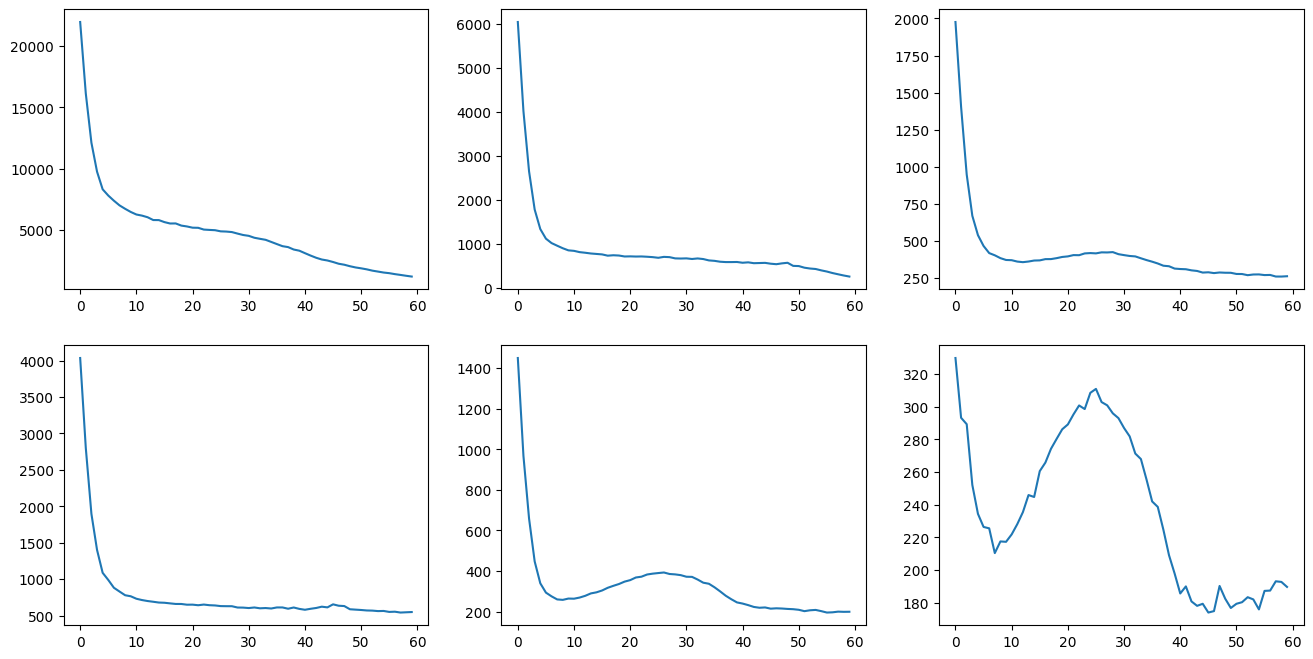

In [13]:
names = [f'domain {i}' for i in range(7)]
target_name = names[-1]

fig, axes = plt.subplots(2, 3, figsize=(16, 8))
for k, dom in enumerate(dictionary.history['loss_per_dataset']):
    axes.flatten()[k].plot(dictionary.history['loss_per_dataset'][dom])

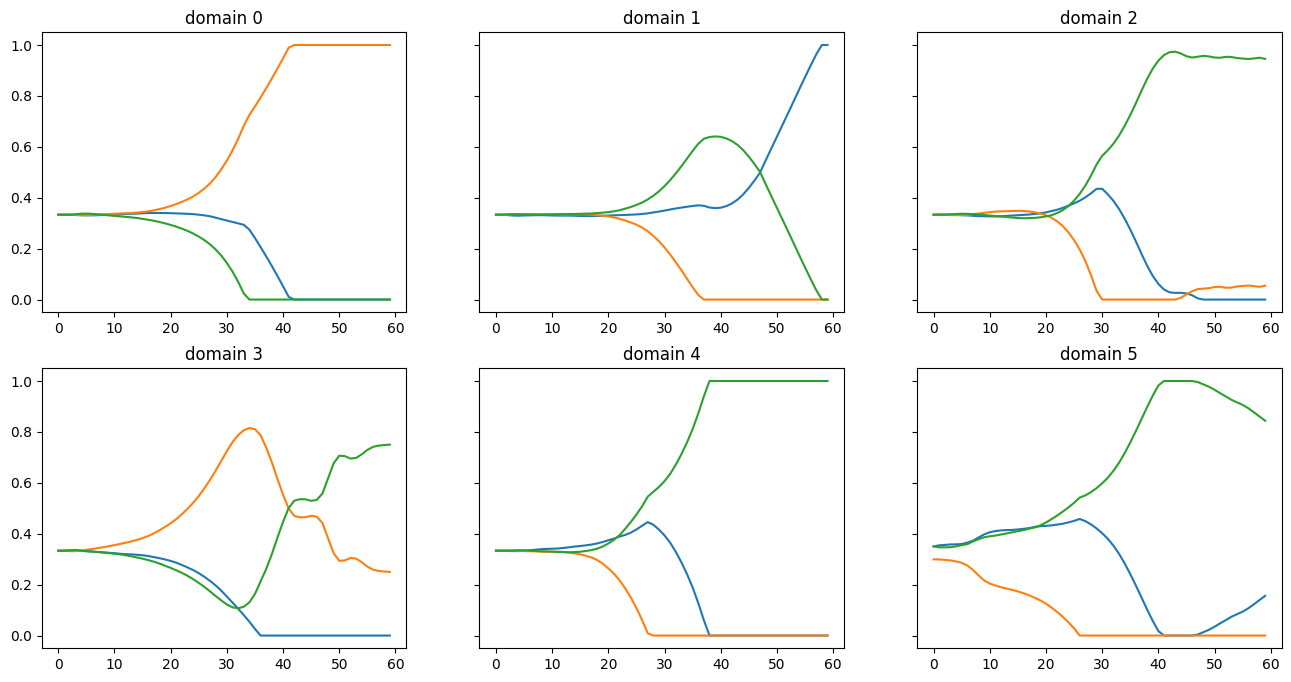

In [14]:
fig, axes = plt.subplots(2, 3, figsize=(16, 8), sharey=True)

for k, (name, ax) in enumerate(zip(names, axes.flatten())):
    ax.plot(torch.stack(dictionary.history['weights'])[:, k, :])
    ax.set_title(name)

In [45]:
weights = dictionary.A[-1, :].detach()
#weights = torch.tensor([1/3, 1/3, 1/3])
print(weights)
XP = [XPk.detach().clone() for XPk in dictionary.XP]
YP = [YPk.detach().clone().softmax(dim=-1) for YPk in dictionary.YP]

Xr, Yr = dictionary.reconstruct(weights=weights)

tensor([0.1560, 0.0000, 0.8440])


Classification without DA

In [101]:
clf = SVC(kernel='rbf')
#clf = RandomForestClassifier()

clf.fit(torch.cat(Xs, dim=0),
        torch.cat(ys, dim=0))
yp = clf.predict(Xt)
print(accuracy_score(yp, yt))

0.908


DaDiL-E

In [98]:
clf = SVC(kernel='linear', probability=True)
#clf = RandomForestClassifier(criterion = 'gini')

predictions = []
for k, (XP_k, YP_k) in enumerate(zip(XP, YP)):
    # Get atom data
    XP_k, YP_k = XP_k.data.cpu(), YP_k.data.cpu()
    yp_k = YP_k.argmax(dim=1)
    
    clf.fit(XP_k, yp_k)
    yp = clf.predict(Xt)
    print("Atom {} w/ weight {} got {}".format(k, np.round(weights[k], 3), accuracy_score(yt, yp)))

    P = clf.predict_proba(Xt)
    predictions.append(P)
predictions = np.stack(predictions)

# Weights atomic model predictions
yp = np.einsum('i,inj->nj', weights, predictions).argmax(axis=1)

# Compute statistics
accuracy_e = accuracy_score(yt, yp)
print(accuracy_e)

Atom 0 w/ weight 0.9599999785423279 got 0.688
Atom 1 w/ weight 0.0 got 0.204
Atom 2 w/ weight 0.03999999910593033 got 0.296
0.912


DaDiL-R

In [95]:
clf = SVC(kernel='linear')
#clf = RandomForestClassifier()

clf.fit(Xr, Yr.argmax(dim=1))
yp = clf.predict(Xt)
accuracy_r = accuracy_score(yp, yt)
print(accuracy_r)

0.772


Final optimal transport to adapt domains

In [86]:
clf = SVC(kernel='rbf', probability=True)
#clf = RandomForestClassifier()

predictions = []
for k, (XP_k, YP_k) in enumerate(zip(XP, YP)):
    # Get atom data
    XP_k, YP_k = XP_k.data.cpu(), YP_k.data.cpu()
    Xt_OGMM = OGMM.sample(XP_k.shape[0])[0]

    weights_k = torch.ones(XP_k.shape[0])/XP_k.shape[0]
    weights_ogmm = torch.ones(Xt_OGMM.shape[0])/Xt_OGMM.shape[0]

    C = torch.cdist(XP_k, Xt_OGMM, p=2) ** 2
    ot_plan = ot.emd(weights_k, weights_ogmm, C, numItermax=1000000)
    Yt_OGMM = ot_plan.T @ YP_k

    yt_ogmm = Yt_OGMM.argmax(dim=1)
    
    clf.fit(Xt_OGMM, yt_ogmm)
    yp = clf.predict(Xt)
    print("Atom {} w/ weight {} got {}".format(k, np.round(weights[k], 3), accuracy_score(yt, yp)))

    P = clf.predict_proba(Xt)
    predictions.append(P)
predictions = np.stack(predictions)

# Weights atomic model predictions
yp = np.einsum('i,inj->nj', weights, predictions).argmax(axis=1)

# Compute statistics
accuracy_e = accuracy_score(yt, yp)
print(accuracy_e)

Atom 0 w/ weight 0.9599999785423279 got 0.848
Atom 1 w/ weight 0.0 got 0.776
Atom 2 w/ weight 0.03999999910593033 got 0.892
0.84


In [80]:
Xt_OGMM = OGMM.sample(Xr.shape[0])[0]

weights_r = torch.ones(Xr.shape[0])/Xr.shape[0]
weights_ogmm = torch.ones(Xt_OGMM.shape[0])/Xt_OGMM.shape[0]

C = torch.cdist(Xr, Xt_OGMM, p=2) ** 2
ot_plan = ot.emd(weights_r, weights_ogmm, C, numItermax=1000000)
Yt_OGMM = ot_plan.T @ Yr

clf = SVC(kernel='rbf')
#clf = RandomForestClassifier(criterion='gini')

clf.fit(Xt_OGMM, Yt_OGMM.argmax(dim=1))
yp = clf.predict(Xt)
accuracy_r = accuracy_score(yp, yt)
print(accuracy_r)

0.944


## Classic Dictionary Learning

In [50]:
Q = []
for Xs_k, ys_k in zip(Xs, ys):
    Q.append(
        SupervisedDatasetMeasure(
            features=Xs_k.numpy(),
            labels=ys_k.numpy(),
            stratify=True,
            batch_size=batch_size,
            device='cpu'
        )
    )
    
Q.append(
    UnsupervisedDatasetMeasure(
        features=Xt.numpy(),
        batch_size=batch_size,
        device='cpu'
    )
)

In [51]:
criterion = JointWassersteinDistance()

In [52]:
dictionary = LabeledDictionaryGMM(XP=None,
                           YP=None,
                           A=None,
                           n_samples=n_samples,
                           n_dim=X.shape[1],
                           n_classes=n_classes,
                           n_components=n_atoms,
                           weight_initialization='uniform',
                           n_distributions=len(Q),
                           loss_fn=criterion,
                           learning_rate_features=1e-1,
                           learning_rate_labels=1e-1,
                           learning_rate_weights=1e-1,
                           reg_e=0.0,
                           n_iter_barycenter=10,
                           n_iter_sinkhorn=20,
                           n_iter_emd=1000000,
                           domain_names=None,
                           grad_labels=True,
                           optimizer_name='Adam',
                           balanced_sampling=True,
                           sampling_with_replacement=True,
                           barycenter_tol=1e-9,
                           barycenter_beta=None,
                           tensor_dtype=torch.float32,
                           track_atoms=False,
                           schedule_lr=False)

In [53]:
dictionary.fit(Q,
               n_iter_max=60,
               batches_per_it=n_samples // batch_size,
               verbose=True)

It 1/60, Loss: 35993.2890625
It 2/60, Loss: 26108.328906250004
It 3/60, Loss: 18825.265625
It 4/60, Loss: 14346.616015624999
It 5/60, Loss: 12288.079101562498
It 6/60, Loss: 10945.387890625001
It 7/60, Loss: 10196.02265625
It 8/60, Loss: 9766.369921875
It 9/60, Loss: 9393.059374999999
It 10/60, Loss: 8989.446875
It 11/60, Loss: 8825.0080078125
It 12/60, Loss: 8617.1693359375
It 13/60, Loss: 8373.505859375
It 14/60, Loss: 8254.8099609375
It 15/60, Loss: 8212.2162109375
It 16/60, Loss: 7940.1169921875
It 17/60, Loss: 7899.903613281251
It 18/60, Loss: 7800.44892578125
It 19/60, Loss: 7745.7146484375
It 20/60, Loss: 7604.662109375
It 21/60, Loss: 7509.50849609375
It 22/60, Loss: 7405.0033203125
It 23/60, Loss: 7294.3279296875
It 24/60, Loss: 7074.34287109375
It 25/60, Loss: 7036.945800781249
It 26/60, Loss: 6844.840527343751
It 27/60, Loss: 6655.052441406249
It 28/60, Loss: 6526.36806640625
It 29/60, Loss: 6301.704687500001
It 30/60, Loss: 6149.08310546875
It 31/60, Loss: 6023.16943359375


In [54]:
names = [f'domain {i}' for i in range(7)]
target_name = names[-1]

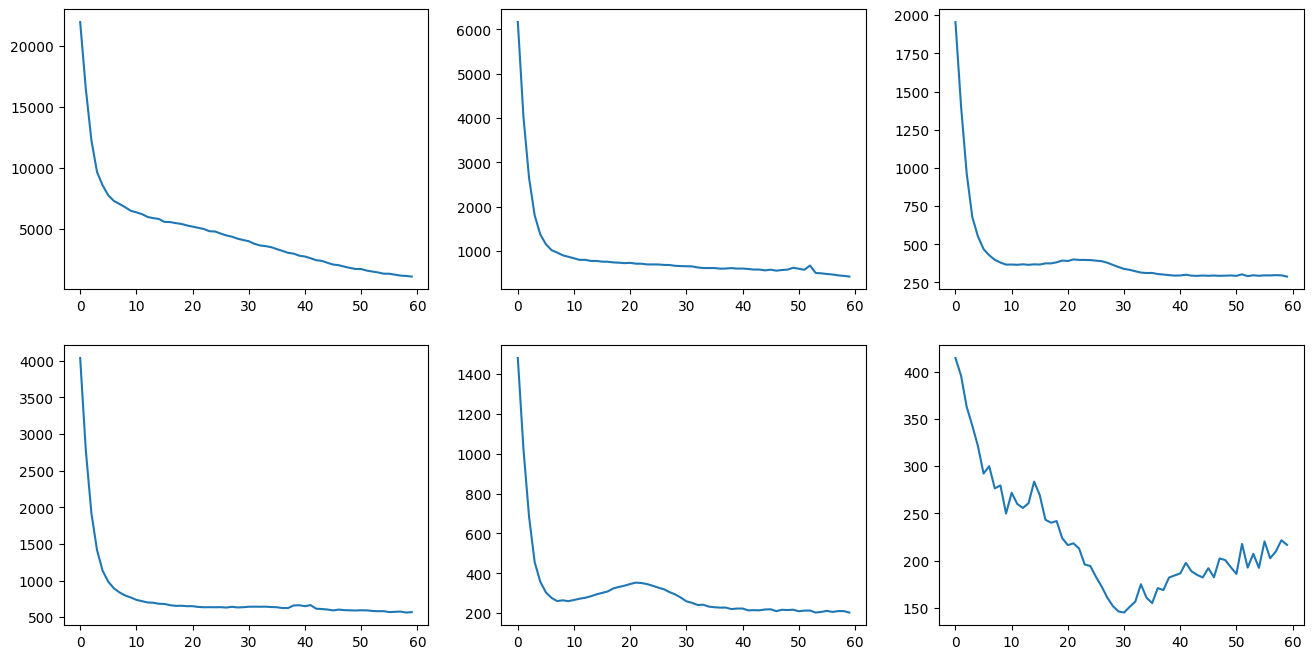

In [55]:
fig, axes = plt.subplots(2, 3, figsize=(16, 8))
for k, dom in enumerate(dictionary.history['loss_per_dataset']):
    axes.flatten()[k].plot(dictionary.history['loss_per_dataset'][dom])

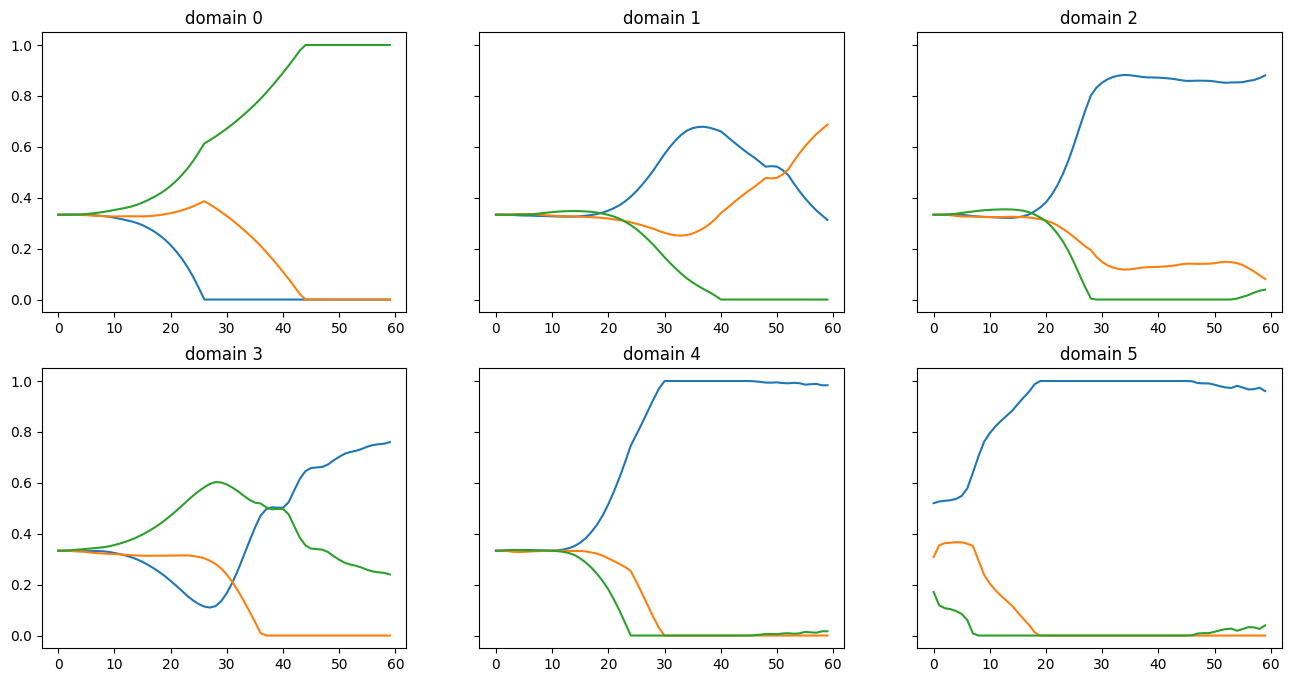

In [56]:
fig, axes = plt.subplots(2, 3, figsize=(16, 8), sharey=True)

for k, (name, ax) in enumerate(zip(names, axes.flatten())):
    ax.plot(torch.stack(dictionary.history['weights'])[:, k, :])
    ax.set_title(name)

In [67]:
weights = dictionary.A[-1, :].detach()
print(weights)
XP = [XPk.detach().clone() for XPk in dictionary.XP]
YP = [YPk.detach().clone().softmax(dim=-1) for YPk in dictionary.YP]

tensor([0.9601, 0.0000, 0.0399])


In [68]:
Xr, Yr = wasserstein_barycenter(
    XP=XP,
    YP=YP,
    n_samples=n_samples,
    weights=weights,
    tol=1e-9,
    n_iter_max=10,
    propagate_labels=True,
    penalize_labels=True
)

Classification without DA

In [75]:
clf = SVC(kernel='rbf')
#clf = RandomForestClassifier()

clf.fit(torch.cat(Xs, dim=0),
        torch.cat(ys, dim=0))
yp = clf.predict(Xt)
print(accuracy_score(yp, yt))

0.908


DaDiL-E

In [72]:
clf = SVC(kernel='linear', probability=True)
#clf = RandomForestClassifier()

predictions = []
for k, (XP_k, YP_k) in enumerate(zip(XP, YP)):
    # Get atom data
    XP_k, YP_k = XP_k.data.cpu(), YP_k.data.cpu()
    yp_k = YP_k.argmax(dim=1)
    
    clf.fit(XP_k, yp_k)
    yp = clf.predict(Xt)
    print("Atom {} w/ weight {} got {}".format(k, np.round(weights[k], 3), accuracy_score(yt, yp)))

    P = clf.predict_proba(Xt)
    predictions.append(P)
predictions = np.stack(predictions)

# Weights atomic model predictions
yp = np.einsum('i,inj->nj', weights, predictions).argmax(axis=1)

# Compute statistics
accuracy_e = accuracy_score(yt, yp)
print(accuracy_e)

Atom 0 w/ weight 0.9599999785423279 got 0.688
Atom 1 w/ weight 0.0 got 0.204
Atom 2 w/ weight 0.03999999910593033 got 0.296
0.912


DaDiL-R

In [73]:
clf = SVC(kernel='linear')
#clf = RandomForestClassifier(criterion='gini')

clf.fit(Xr, Yr.argmax(dim=1))
yp = clf.predict(Xt)
accuracy_r = accuracy_score(yp, yt)
print(accuracy_r)

0.772
